<h1>Chick for GPU</h1>

In [4]:
from platform import python_version
print("Current Python Version :", python_version())
import tensorflow as tf
print("Current tensorflow Version :",tf.__version__)
print("state gpu :",tf.test.is_gpu_available())
print("state gpu :",tf.test.is_built_with_cuda())
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Current Python Version : 3.7.0
Current tensorflow Version : 2.4.1
state gpu : True
state gpu : True


True

In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


<h1>Import tools</h1>

In [6]:
from tensorflow.keras.utils import Sequence
from n2v.models import N2VConfig, N2V
import numpy as np
from tensorflow.keras.optimizers import Adam
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import cv2 

<h1>noise method</h1>

In [7]:
def addnoise(img):
    image =img.copy()
    channels = []
    if len(image.shape)==2:
        channels.append(image)
    elif len(image.shape)==3:
        channels = cv2.split(image)
    for channel in channels:
        for X in range(len(channel)):
            for Y in range(len(channel[X])):
                if np.random.randint(1000)%np.random.randint(1,4)==0:
                    channel[X][Y] = np.random.randint(256)
    if len(channels)==3:
        image = cv2.merge((channels[0],channels[1],channels[2]))
    else:
        image =channels[0]
    return image

<h1>Read single image</h1>

In [8]:
def reshape(image):
    import cv2
    reshapedimage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return reshapedimage.astype("float32")
def convert2uint8(image):
    return image.astype("uint8")

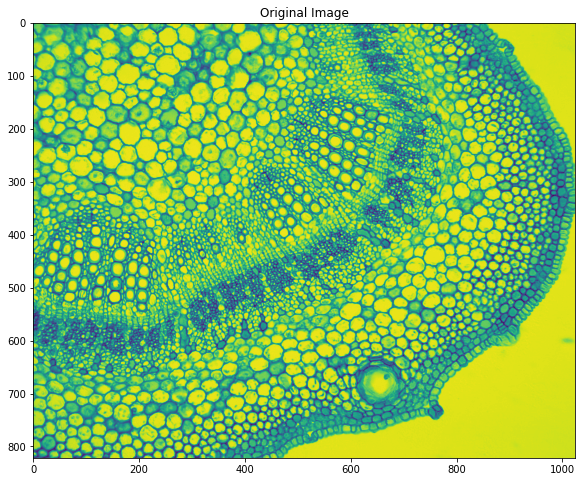

In [15]:
#load
path = "C:/Users/DELL/Desktop/GP/in/photos/Cell2.jpg"
originalimage = cv2.imread(path)
originalimage = cv2.cvtColor(originalimage, cv2.COLOR_BGR2GRAY)
#originalimage = cv2.cvtColor(originalimage, cv2.COLOR_BGR2RGB)
#display
plt.figure(figsize=(16,8))
plt.title("Original Image")
plt.imshow(originalimage)
plt.show()

<h1>Create noisy image</h1>

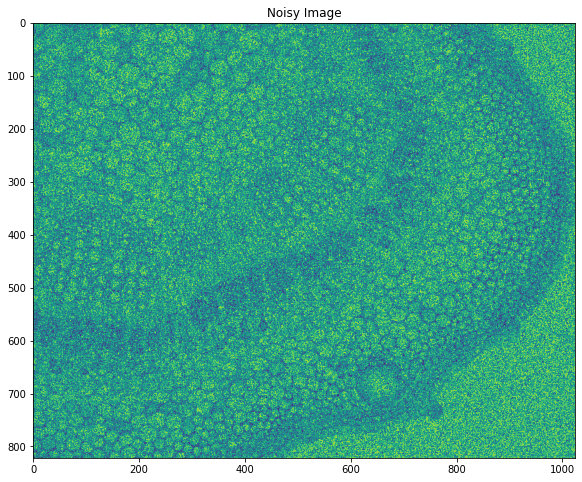

In [16]:
#noising
noisyimage=addnoise(originalimage)

#display
plt.figure(figsize=(16,8))
plt.title("Noisy Image")
plt.imshow(noisyimage)
plt.show()

<h1>built N2V model class</h1>

In [18]:
class N2VModel:
    def __init__(self):
        self.model=None
        self.history=None
    def __genetateData(self,img):
        #estimate patch_size based on number of pixels
        patch_size = 64
        pixels=img.shape[0]*img.shape[1]
        if pixels < 640000:
            patch_size = 32
        elif pixels > 640000*2 :
            patch_size = 128
        patch_shape=(patch_size,patch_size)
        
        datagen = N2V_DataGenerator()
        #reshape image to extrat batchs
        image = self.__reshape(img)
        patches = datagen.generate_patches_from_list([image], shape=patch_shape)
        
        #estimate training and testnig size
        if len(patches) >=5000:
            boundry = int(0.9 * len(patches))
        else :
            boundry = int(0.7 * len(patches))
        X = patches[:boundry]
        X_val = patches[boundry:]

        data= {"training":X,"validation":X_val,"patchsize":patch_size}
        return data
            
    def __config(self,img,X,patch_size,patch_shape):
        if len(img.shape)==3:
            config = N2VConfig(X, unet_kern_size=3, 
                           unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/X.shape[1]), train_loss='mse', 
                           batch_norm=True, train_batch_size=patch_size, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)
        else :
            config = N2VConfig(X, unet_kern_size=3, 
                           train_steps_per_epoch=int(X.shape[0]/X.shape[1]), train_epochs=100, train_loss='mse', batch_norm=True, 
                           train_batch_size=patch_size, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                           n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)
        return config

    def train(self,img,stordir,epochs=200,model_name='n2v_2D'):
        #generate data training and validation
        data = self.__genetateData(img)
        X= data["training"]
        X_val= data["validation"]
        patchSize=data["patchsize"]
        patch_shape=(patchSize,patchSize)
        #configration 
        config = self.__config(img,X,patchSize,patch_shape)
        self.model = N2V(config, model_name, basedir=stordir)
        self.model.config.train_epochs=epochs
        self.history = self.model.train(X, X_val)
    def predict(self,img):
        if len(img.shape)==3:
            axes ="YXC" 
        else :
            axes = "YX"
        predicted = self.model.predict(img.astype("float32"), axes=axes)
        return predicted.astype("uint8")
    def loadmodel(self,path,model_name='n2v_2D'):
        self.model= N2V(config=None, name=model_name, basedir=path)
        return True
    def __reshape(self,image):
        if len(image.shape)==2:
            img = image.reshape(tuple([1]+list(image.shape)+[1]))
        elif len(image.shape)==3:
            img = image.reshape(tuple([1]+list(image.shape)))
        return img

<h1>train the model by single noise image</h1>

In [15]:
model = N2VModel()
model.train(noisyimage,stordir="C:/Users/DELL/Desktop/GP/savedmodels",model_name="Cell")

Generated patches: (2240, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|███████████████████████████████████████████████████| 672/672 [00:00<00:00, 2902.48it/s]


Epoch 1/200
24/24 [==============================] - 9s 186ms/step - loss: 1.6033 - n2v_mse: 1.6033 - n2v_abs: 1.0284 - val_loss: 0.9895 - val_n2v_mse: 0.9895 - val_n2v_abs: 0.8632
Epoch 2/200
24/24 [==============================] - 3s 140ms/step - loss: 1.3008 - n2v_mse: 1.3008 - n2v_abs: 0.9355 - val_loss: 0.9909 - val_n2v_mse: 0.9909 - val_n2v_abs: 0.8632
Epoch 3/200
24/24 [==============================] - 3s 139ms/step - loss: 1.1757 - n2v_mse: 1.1757 - n2v_abs: 0.8953 - val_loss: 1.0086 - val_n2v_mse: 1.0086 - val_n2v_abs: 0.8689
Epoch 4/200
24/24 [==============================] - 3s 140ms/step - loss: 1.0895 - n2v_mse: 1.0895 - n2v_abs: 0.8681 - val_loss: 1.0160 - val_n2v_mse: 1.0160 - val_n2v_abs: 0.8707
Epoch 5/200
24/24 [==============================] - 3s 141ms/step - loss: 1.0440 - n2v_mse: 1.0440 - n2v_abs: 0.8575 - val_loss: 1.0227 - val_n2v_mse: 1.0227 - val_n2v_abs: 0.8708
Epoch 6/200
24/24 [==============================] - 4s 142ms/step - loss: 1.0046 - n2v_mse: 1.

<h1>Display loss & val loss</h1>

In [39]:
print(sorted(list(model.history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(model.history,['loss','val_loss'])

<h1>load trained model</h1>

In [20]:
model = N2VModel()
model.loadmodel(path="C:/Users/DELL/Desktop/GP/savedmodels",model_name="Cell")

Loading network weights from 'weights_best.h5'.


True

<h1>load noisy Image</h1>

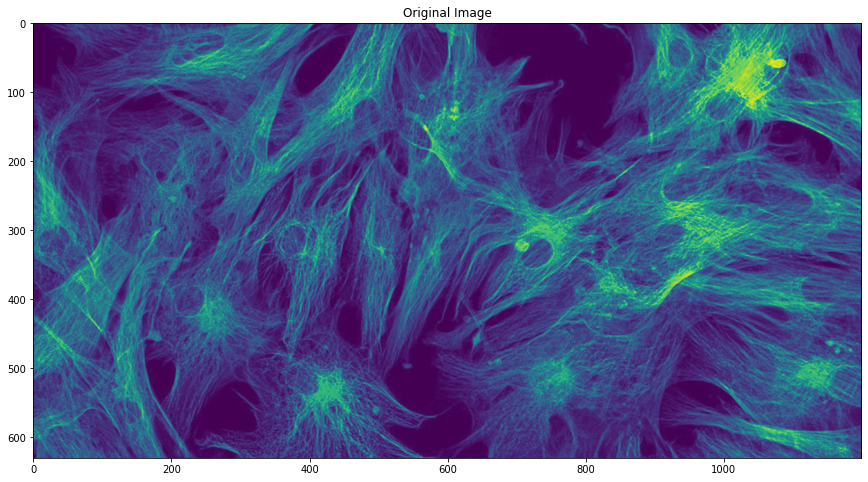

In [21]:
#load
path = "C:/Users/DELL/Desktop/GP/in/photos/BIO.jpg"
originalimage = cv2.imread(path)
originalimage = cv2.cvtColor(originalimage, cv2.COLOR_BGR2GRAY)
#originalimage = cv2.cvtColor(originalimage, cv2.COLOR_BGR2RGB)
#display
plt.figure(figsize=(16,8))
plt.title("Original Image")
plt.imshow(originalimage)
plt.show()

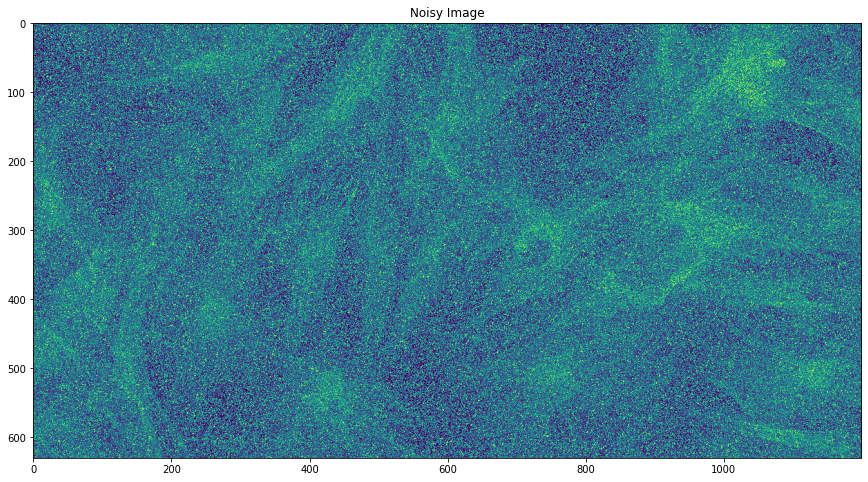

In [22]:
#noising
noisyimage=addnoise(originalimage)

#display
plt.figure(figsize=(16,8))
plt.title("Noisy Image")
plt.imshow(noisyimage)
plt.show()

<h1>Pridect</h1>

In [23]:
pred = model.predict(noisyimage)

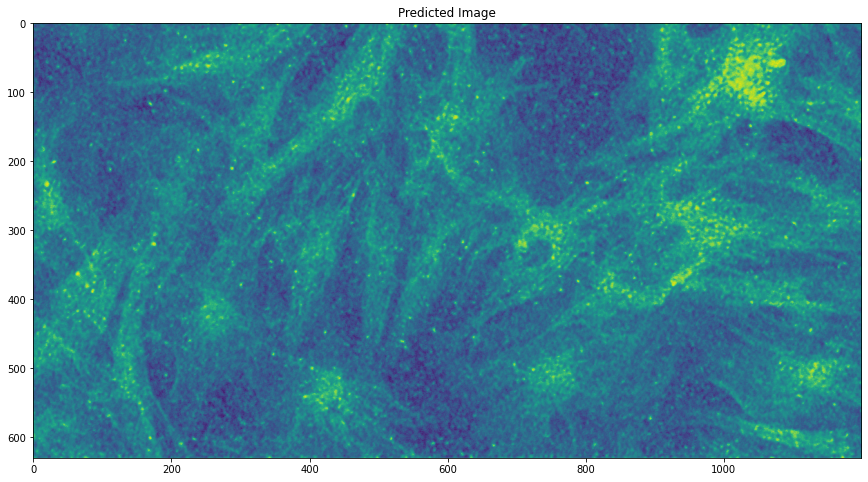

In [33]:
#display
plt.figure(figsize=(16,8))
plt.title("Predicted Image")
plt.imshow(pred)
plt.show()

<h1>Display input image and predicted image</h1>

PSNR values : 27.661379749612323 dB


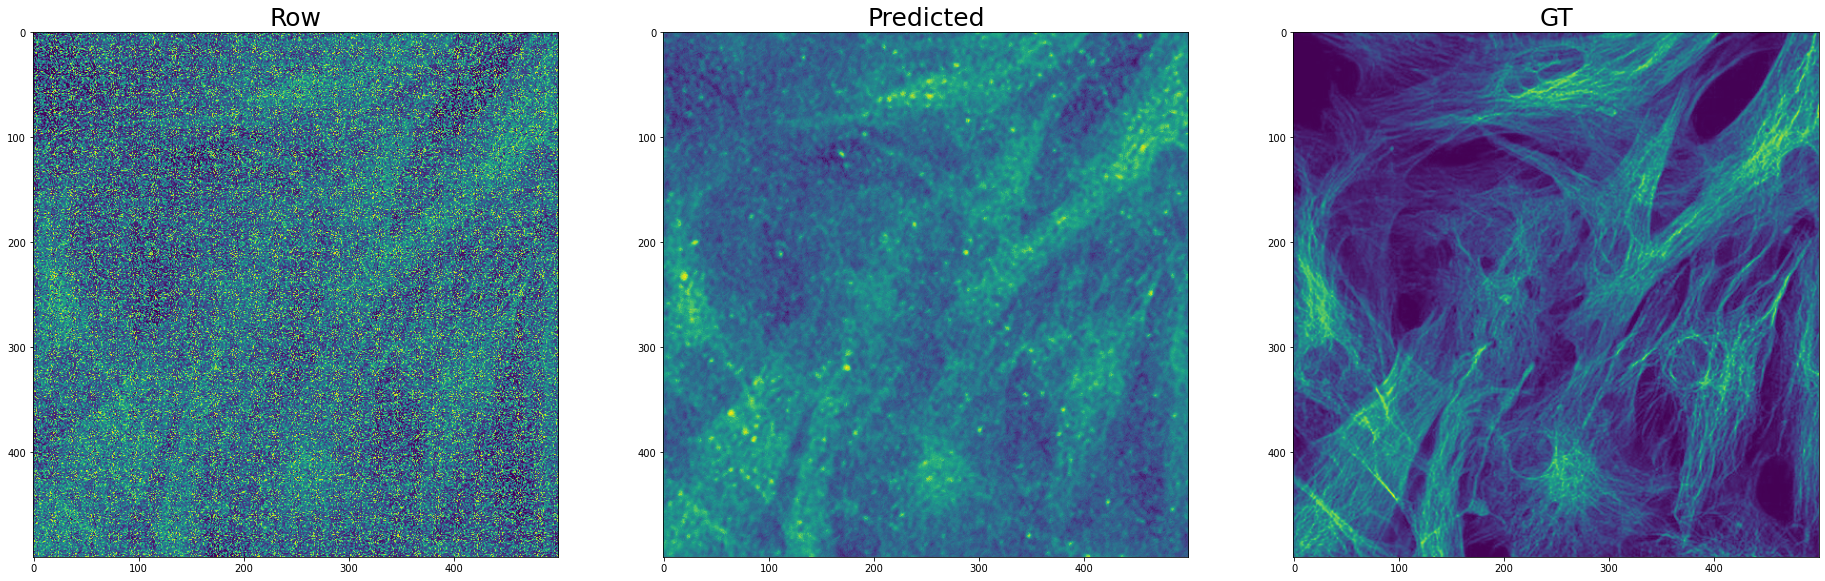

In [38]:
pix = 0
piy = 500
print(f"PSNR values : {Psnr} dB")
plt.figure(figsize=(32,16))
plt.subplot(1,3,1)
plt.title("Row",fontdict={'fontsize': 25})
plt.imshow(noisyimage[pix:piy,pix:piy])
plt.subplot(1,3,2)
plt.title("Predicted",fontdict={'fontsize': 25})
plt.imshow(pred[pix:piy,pix:piy])
plt.subplot(1,3,3)
plt.title("GT",fontdict={'fontsize': 25})
plt.imshow(originalimage[pix:piy,pix:piy])
plt.show()

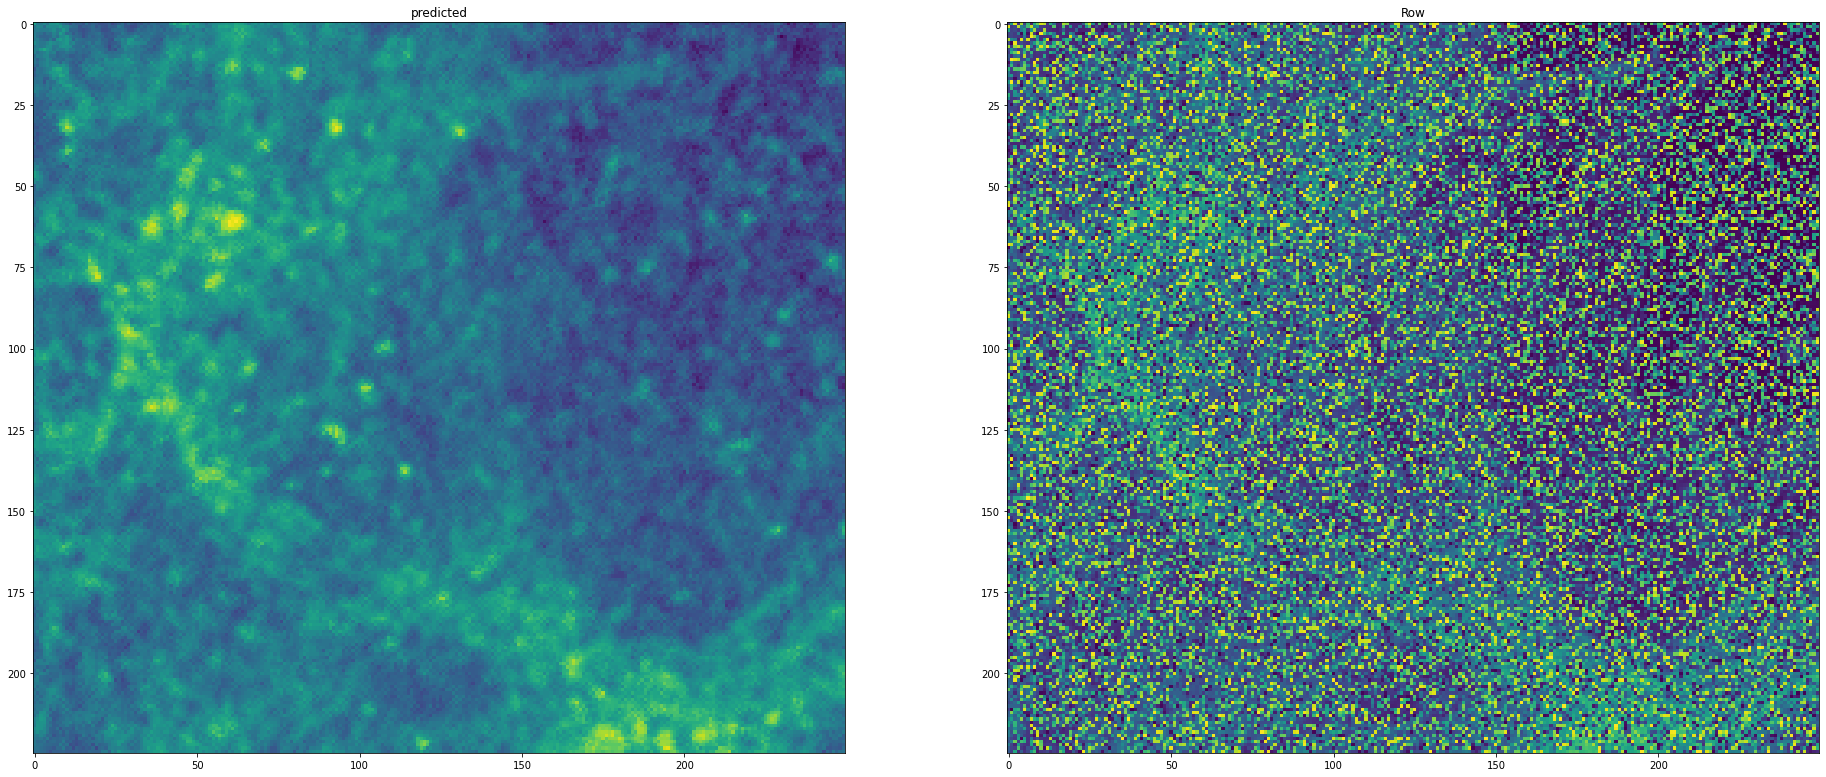

In [29]:
plt.figure(figsize=(32,16))
plt.subplot(1,2,1)
plt.title("predicted")
plt.imshow(pred[75:300,550:800])
plt.subplot(1,2,2)
plt.title("Row")
plt.imshow(noisyimage[75:300,550:800])
plt.show()

PSNR values : 27.661379749612323 dB


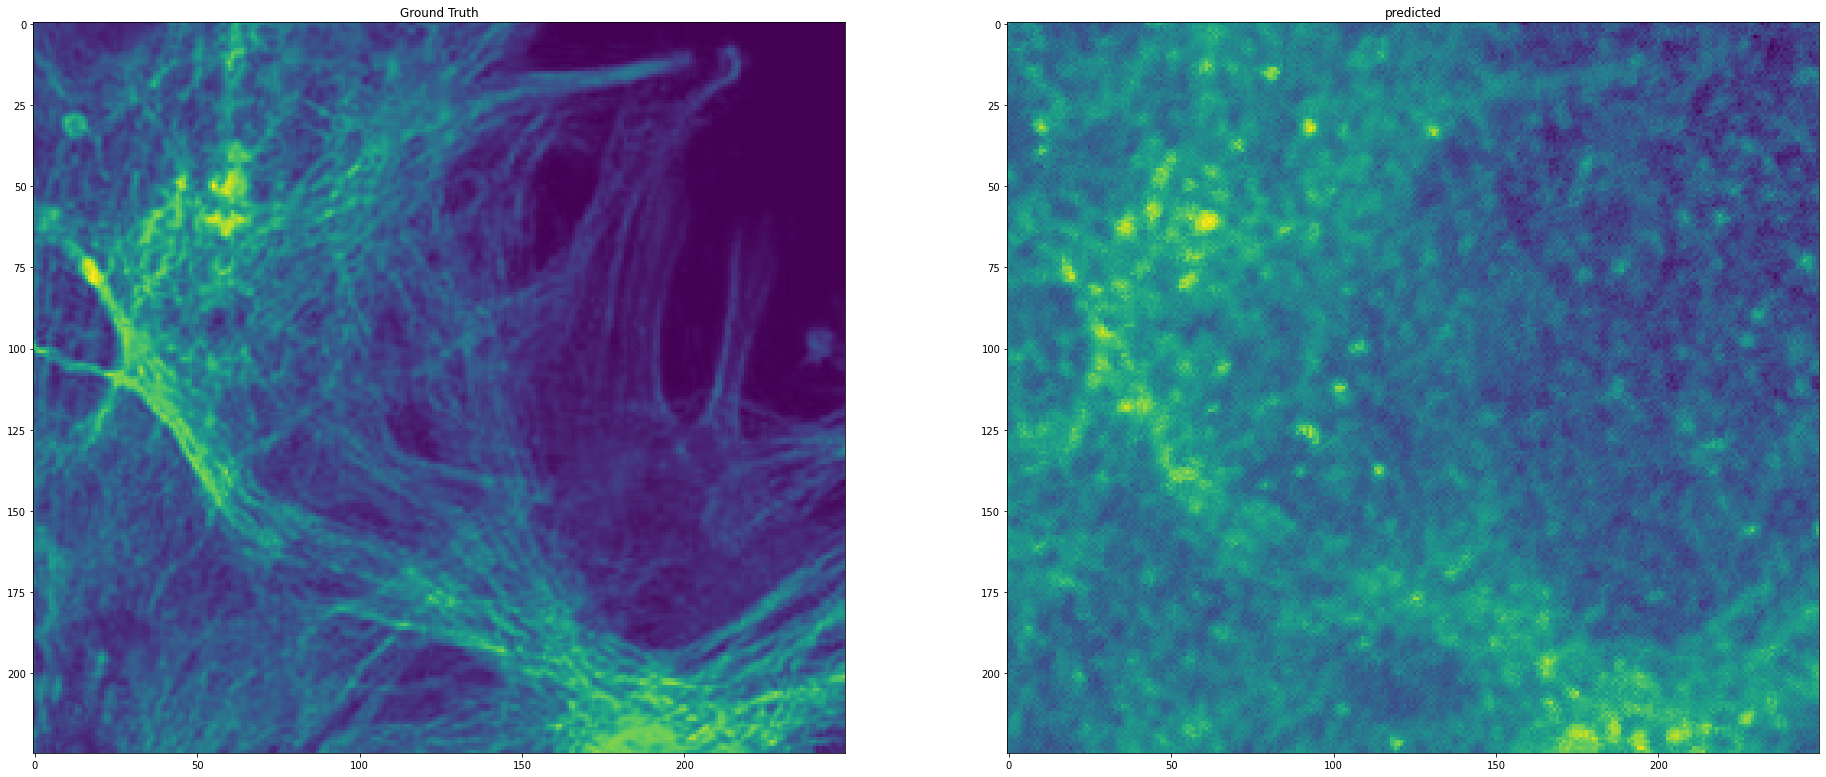

In [37]:
print(f"PSNR values : {Psnr} dB")
plt.figure(figsize=(32,16))
plt.subplot(1,2,1)
plt.title("Ground Truth")
plt.imshow(originalimage[75:300,550:800])
plt.subplot(1,2,2)
plt.title("predicted")
plt.imshow(pred[75:300,550:800])
plt.show()

<h1>Calculate PSNR</h1>

In [36]:
from math import log10, sqrt

def PSNR(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    if(mse == 0): # MSE is zero means no noise is present in the signal .
                # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

Psnr = PSNR(originalimage, pred)

print(f"PSNR values : {Psnr} dB")

PSNR values : 27.661379749612323 dB


<h1>save result</h1>

In [41]:
path ="C:/Users/DELL/Desktop/GP/in/savedmodels/predicted.png"
cv2.imwrite(path,pred)